In [1]:
import os
os.chdir("../")
import sys
import pandas as pd
import numpy as np
import shapely
import geopandas as gpd
import math
import folium
import matplotlib.pyplot as plt
%matplotlib inline

try: 
    import contextily as cx
except:
    !{sys.executable} -m pip install --upgrade contextily
    import contextily as cx
    
import warnings
warnings.filterwarnings("ignore")

## HSI

In [2]:
hsipath = os.getcwd() + "/data/hsi/Heat_Sensitivity_Exposure_Index.shp"

In [3]:
gdf = gpd.read_file(hsipath)
gdf["HSI"] = gdf["HSI"].apply(lambda x: 0 if x < 0 else x)

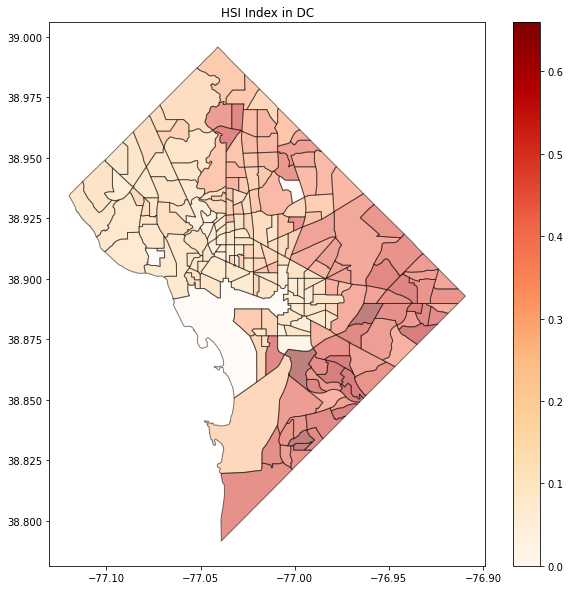

In [4]:
ax = gdf.plot(figsize=(10, 10), column="HSI",
              cmap="OrRd", alpha=0.5,
              legend=True, edgecolor="k")
ax.set_title("HSI Index in DC")
plt.show()

In [ ]:
m = folium.Map(location=[38.897957, -77.036560],
               zoom_start=12, tiles="CartoDB positron")
for _, r in gdf.iterrows():

    gj = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.0001).to_json()
    folium.GeoJson(data=gj,
                   style_function=lambda x: 
                   {"fillColor": "red", 
                    "weight":1}).add_to(m)
    folium.CircleMarker(location=[r["geometry"].centroid.y, r["geometry"].centroid.x],
                        radius=2,
                        popup=folium.Popup(
                            str(r["NAME"].split(", ")[0]) + "<br>" +
                            str("\ HSI: ") + str(r["HSI"]),
        min_width=200, max_width=200)).add_to(m)
display(m)

## Election

In [6]:
def preprocess_data(data,
                    columns=["name", "g20prertru", "g20predbid", "geometry"]):

    data.columns = [col.lower() for col in data.columns]
    if "voter_num" not in columns:
        data["voter_num"] = data[[
            col for col in data.columns if col.startswith("g20pre")
        ]].sum(axis=1)
        columns.append("voter_num")
    election_data = data[columns]
    election_data["blue"] = (election_data["g20predbid"] >=
                             election_data["g20prertru"])
    election_data["blue_share"] = (election_data["g20predbid"]) / (
        election_data["voter_num"])
    election_data = (election_data.reset_index().drop(
        "index", axis=1).to_crs("EPSG:4326"))

    return election_data

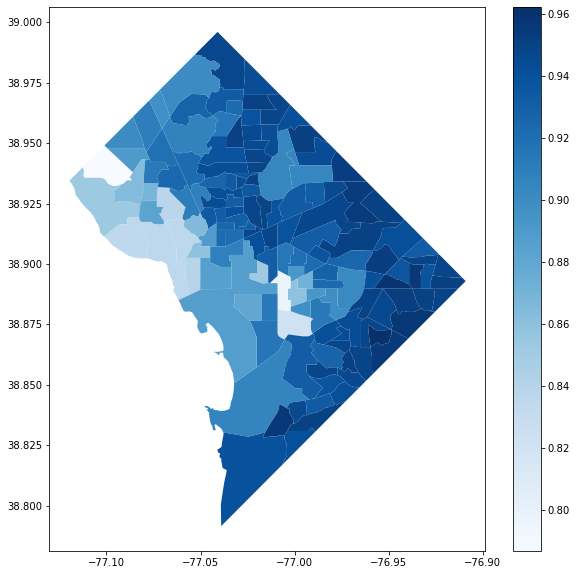

In [7]:
dc = gpd.read_file(os.getcwd() + "/data/dc_2020.zip")
dc_pre = preprocess_data(dc)
dc_pre.plot(figsize=(10, 10), column="blue_share",
            cmap="Blues", legend=True);

<AxesSubplot:>

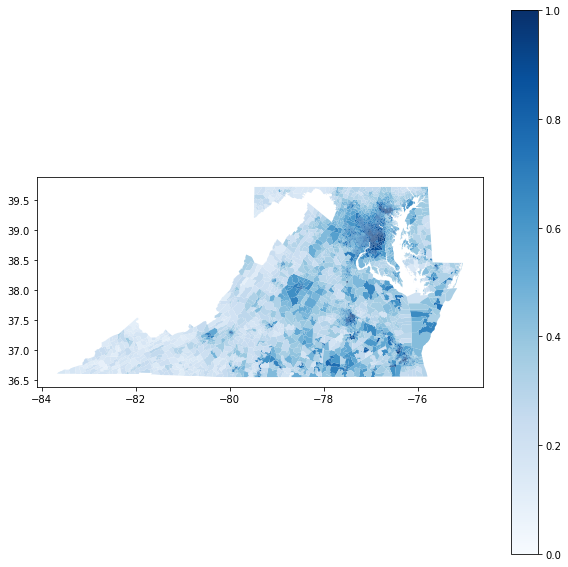

In [8]:
combos = [("dc", "name"), ("va", "precinct"), ("md", "name")]

dmv_pre = gpd.pd.DataFrame()
for (state, name) in combos:
    data = gpd.read_file(os.getcwd() + f"/data/{state}_2020.zip")
    data_pre = preprocess_data(
        data, columns=[str(name), "g20prertru", "g20predbid", "geometry"])
    data_pre[str(name)] = [str(state) + "_" + name.lower().replace(" ", "_") 
                           for name in data_pre[str(name)]]
    if dmv_pre.empty:
        dmv_pre = data_pre
    else:
        dmv_pre = (gpd.pd.concat([dmv_pre, data_pre])
                      .reset_index()
                      .drop("index", axis=1))
dmv_pre["name"].fillna(dmv_pre["precinct"], inplace=True)

dmv_pre.plot(figsize=(10, 10), column="blue_share", cmap="Blues", legend=True)

In [9]:
dmv_pre["color"] = ["blue" if col == True else "red" for col in dmv_pre.blue]

In [10]:
em = folium.Map(location=[38.897957, -77.036560],
                zoom_start=10,
                tiles="CartoDB positron")

for _, r in dmv_pre.iterrows():

    if type(r["name"]) == str:
        pass
    else:
        r["name"] = r["precinct"]

    gj = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.0001).to_json()
    fillColor, fillOpacity = r["color"], abs(r["blue_share"] - 0.5)
    folium.GeoJson(data=gj,
                   style_function=lambda x, fileColor=fillColor, fillOpacity=
                   fillOpacity: {
                       "fillColor": fileColor,
                       "fillOpacity": fillOpacity,
                       "weight": 1
                   }).add_to(em)

    folium.CircleMarker(
        location=[r["geometry"].centroid.y, r["geometry"].centroid.x],
        radius=1,
        color=fillColor,
        popup=folium.Popup(str(r["name"]) + "<br>" + str(r["g20predbid"]) +
                           " out of " + str(r["voter_num"]) +
                           " voters voted for Biden in 2020.",
                           min_width=200,
                           max_width=200)).add_to(em)

In [11]:
em.save(os.getcwd() + "/output/DMV_2020_PreElec.html")

## Spatial Autocorrelation

In [12]:
dmv_w = dmv_pre.drop("precinct", axis=1).fillna(0)

In [13]:
from pysal.lib import weights

w = weights.KNN.from_dataframe(dmv_w, k=8)
w.transform = "R" 

In [14]:
dmv_w["blue_share_lag"] = weights.spatial_lag.lag_spatial(
    w, dmv_w["blue_share"])

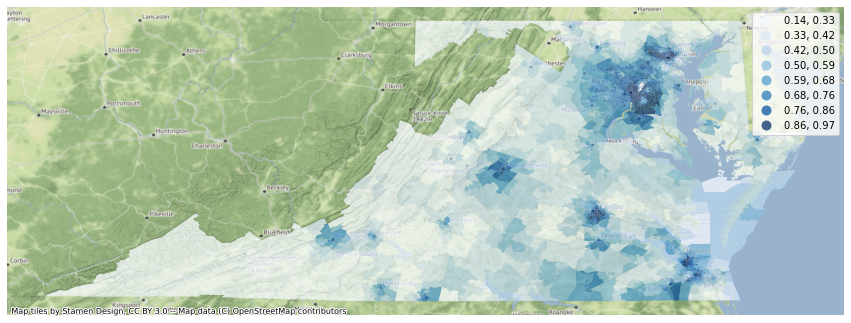

In [15]:
fig, ax = plt.subplots(figsize=(15, 15))
dmv_w.plot(column="blue_share_lag",
           scheme="quantiles",
           k=8,
           cmap="Blues",
           edgecolor="white",
           linewidth=0.0,
           alpha=0.75,
           legend=True,
           ax=ax)
ax.set_axis_off()
cx.add_basemap(ax, crs=dmv_w.crs)